In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.distributed as dist
from torchvision import datasets
import wandb

from ddbm import dist_util, logger
from datasets import load_data
from ddbm.resample import create_named_schedule_sampler
from ddbm.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    sample_defaults,
    args_to_dict,
    add_dict_to_argparser,
    get_workdir
)
from ddbm.train_util import TrainLoop

from datasets import InfiniteBatchSampler
from datasets.augment import AugmentPipe

## Data

In [ ]:
from pix2pix_utils import load_data

In [6]:
train_loader, val_loader, de_normalize_a, de_normalize_b = load_data(data_dir="data", dataset="cityscapes", batch_size=8, image_size=256)

Precomputing statistics (mean, std)...


100%|██████████| 2975/2975 [00:13<00:00, 226.87it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9231278569620258e-08..1.0000000028175027].


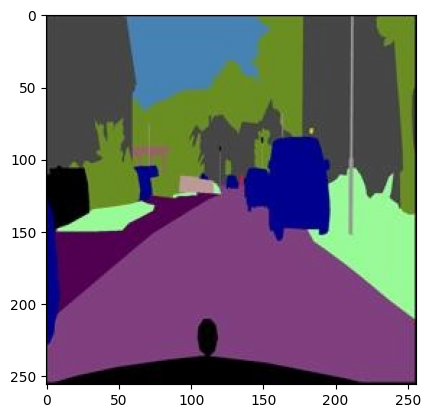

In [7]:
batch = next(iter(train_loader))
plt.imshow(de_normalize_b(batch[1][0]).numpy())
plt.show()

## Training

In [ ]:
devices = [4]

In [9]:
"""
Train a diffusion model on images.
"""

def train(args):

    workdir = get_workdir(args.exp)
    Path(workdir).mkdir(parents=True, exist_ok=True)
    
    dist_util.setup_dist(devices=devices)
    logger.configure(dir=workdir)
    if dist.get_rank() == 0:
        name = args.exp if args.resume_checkpoint == "" else args.exp + '_resume'
        wandb.init(project="bridge", group=args.exp,name=name, config=vars(args), mode='online' if not args.debug else 'disabled')
        logger.log("creating model and diffusion...")
    

    # data_image_size = args.image_size
    

    if args.resume_checkpoint == "":
        model_ckpts = list(glob(f'{workdir}/*model*[0-9].*'))
        if len(model_ckpts) > 0:
            max_ckpt = max(model_ckpts, key=lambda x: int(x.split('model_')[-1].split('.')[0]))
            if os.path.exists(max_ckpt):
                args.resume_checkpoint = max_ckpt
                if dist.get_rank() == 0:
                    logger.log('Resuming from checkpoint: ', max_ckpt)


    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
    model.to(dist_util.dev())

    if dist.get_rank() == 0:
        wandb.watch(model, log='all')
    schedule_sampler = create_named_schedule_sampler(args.schedule_sampler, diffusion)

    
    if args.batch_size == -1:
        batch_size = args.global_batch_size // dist.get_world_size()
        if args.global_batch_size % dist.get_world_size() != 0:
            logger.log(
                f"warning, using smaller global_batch_size of {dist.get_world_size()*batch_size} instead of {args.global_batch_size}"
            )
    else:
        batch_size = args.batch_size
        
    if dist.get_rank() == 0:
        logger.log("creating data loader...")

    # data, test_data = load_data(
    #     data_dir=args.data_dir,
    #     dataset=args.dataset,
    #     batch_size=batch_size,
    #     image_size=data_image_size,
    #     num_workers=args.num_workers,
    # )

    data, test_data, de_normalize_a, de_normalize_b = load_data(data_dir=args.data_dir, 
                                                                dataset=args.dataset, 
                                                                batch_size=batch_size, 
                                                                image_size=args.image_size)
    
    if args.use_augment:
        augment = AugmentPipe(
                p=0.12,xflip=1e8, yflip=1, scale=1, rotate_frac=1, aniso=1, translate_frac=1
            )
    else:
        augment = None
        
    logger.log("training...")
    TrainLoop(
        model=model,
        diffusion=diffusion,
        train_data=data,
        test_data=test_data,
        batch_size=batch_size,
        microbatch=args.microbatch,
        lr=args.lr,
        ema_rate=args.ema_rate,
        log_interval=args.log_interval,
        test_interval=args.test_interval,
        save_interval=args.save_interval,
        save_interval_for_preemption=args.save_interval_for_preemption,
        resume_checkpoint=args.resume_checkpoint,
        workdir=workdir,
        use_fp16=args.use_fp16,
        fp16_scale_growth=args.fp16_scale_growth,
        schedule_sampler=schedule_sampler,
        weight_decay=args.weight_decay,
        lr_anneal_steps=args.lr_anneal_steps,
        augment_pipe=augment,
        **sample_defaults()
    ).run_loop()


In [ ]:
from ddbm_train_dist import train

In [10]:
def model_and_diffusion_defaults():
    """
    Defaults for image training.
    """
    res = dict(
        sigma_data=0.5,
        sigma_min=0.0001,
        sigma_max=1.0,
        beta_d=2,
        beta_min=0.1,
        cov_xy=0.5**2 / 2,  # default: 0
        image_size=64,
        in_channels=3,
        num_channels=64,
        num_res_blocks=2,
        num_heads=4,  # will be ignored if num_head_channels is set
        num_heads_upsample=-1,
        num_head_channels=32,  # -1 for simple attention (num_heads = [2, 4, 8, 16])
        unet_type='adm',
        attention_resolutions="16,8,4", #"32,16,8",
        channel_mult="",  # auto choose, depends on image_size
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_fp16=True,  # False with simple attention
        use_new_attention_order=False,
        attention_type='flash',
        learn_sigma=False,
        condition_mode=None,
        pred_mode='vp',
        weight_schedule="karras",
    )
    return res


def create_argparser():
    defaults = dict(
        exp='0',
        data_dir="data",
        dataset="cityscapes",
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=256,  # set to -1 to use global_batch_size
        global_batch_size=-1,  # 2048
        microbatch=-1,  # -1 disables microbatches
        ema_rate="0.9999",  # comma-separated list of EMA values
        log_interval=50,
        test_interval=500,
        save_interval=10000,
        save_interval_for_preemption=50000,
        resume_checkpoint="",
        use_fp16=True,  # False with simple attention
        fp16_scale_growth=1e-3,
        debug=False,
        num_workers=2,
        use_augment=False
    )
    defaults.update(model_and_diffusion_defaults())
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser


args = create_argparser().parse_args(args=[])

In [ ]:
train(args)

## Sampling

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
samples = np.load("workdir/2_real2cartoon/sample_32000/w=1.0_churn=0.0/samples_500x64x64x3_nfe79.npz")

In [ ]:
# samples = np.load("workdir/3_maps/sample_5000/w=1.0_churn=0.33/path.npz.npy")

In [46]:
# plt.imshow(((samples[0][0].transpose(1, 2, 0) + 1) / 2 * 255.0).round().astype(int))

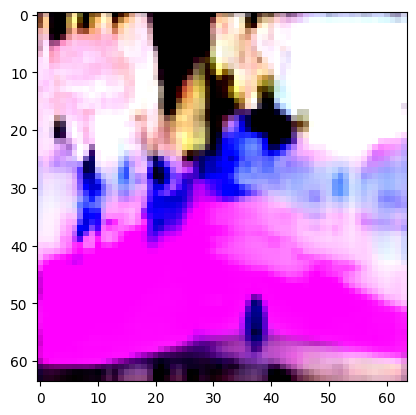

In [59]:
plt.imshow(samples['arr_0'][45])